In [21]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Subset, TensorDataset

DATA_DIR = "/kaggle/input/sign-language-mnist"
TRAIN_DATA_DIR = os.path.join(DATA_DIR, "sign_mnist_train")
TEST_DATA_DIR = os.path.join(DATA_DIR, "sign_mnist_test")
TRAIN_DATA_PATH = os.path.join(TRAIN_DATA_DIR, "sign_mnist_train.csv")
TEST_DATA_PATH = os.path.join(TEST_DATA_DIR, "sign_mnist_test.csv")
RANDOM_SEED = 42
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
print("Using device: {}".format(DEVICE))

Using device: cpu


# Loading the data

In [23]:
training_data = pd.read_csv(TRAIN_DATA_PATH)
training_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [24]:
training_data.shape

(27455, 785)

In [25]:
testing_data = pd.read_csv(TEST_DATA_PATH)
testing_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [26]:
testing_data.shape

(7172, 785)

We can see that we have 27.455 training examples as well as 7.172 testing examples.

# Transforming the data

In [27]:
# Displaying class labels (training data)
np.unique(training_data["label"].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [28]:
# Computing the number of objects for each class (training data)
np.bincount(training_data["label"].values)

array([1126, 1010, 1144, 1196,  957, 1204, 1090, 1013, 1162,    0, 1114,
       1241, 1055, 1151, 1196, 1088, 1279, 1294, 1199, 1186, 1161, 1082,
       1225, 1164, 1118])

In [29]:
np.unique(testing_data["label"].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [30]:
np.bincount(testing_data["label"].values)

array([331, 432, 310, 245, 498, 247, 348, 436, 288,   0, 331, 209, 394,
       291, 246, 347, 164, 144, 246, 248, 266, 346, 206, 267, 332])

In [31]:
def adjust_class_labels(label):
    """Subtracts one from the label when greater than 9."""
    if label >= 10:
        label -= 1
    
    return label

In [32]:
# Adjusting the class labels (training data)
training_data["label"] = training_data["label"].apply(adjust_class_labels)

In [33]:
# Verifying the new class labels
np.unique(training_data["label"].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [34]:
# Verifying the counts
np.bincount(training_data["label"].values)

array([1126, 1010, 1144, 1196,  957, 1204, 1090, 1013, 1162, 1114, 1241,
       1055, 1151, 1196, 1088, 1279, 1294, 1199, 1186, 1161, 1082, 1225,
       1164, 1118])

In [35]:
testing_data["label"] = testing_data["label"].apply(adjust_class_labels)

In [36]:
np.unique(testing_data["label"].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [37]:
np.bincount(testing_data["label"].values)

array([331, 432, 310, 245, 498, 247, 348, 436, 288, 331, 209, 394, 291,
       246, 347, 164, 144, 246, 248, 266, 346, 206, 267, 332])

# Creating Datasets

In [38]:
# Separating features from target (training)
target = training_data["label"].values
features = training_data.drop("label", axis=1).values

# Separating features from target (testing)
target_test = testing_data["label"].values
features_test = testing_data.drop("label", axis=1).values

In [39]:
# Reshaping the training/testing data for NN
features = features.reshape(-1, 1, 28, 28)
features_test = features_test.reshape(-1, 1, 28, 28)

In [40]:
# Rescaling the features (training + testing)
features_scaled = features / 255
features_test_scaled = features_test / 255

In [41]:
# Converting NumPy arrays to Torch tensors (training)
y_train = torch.from_numpy(target).float()
x_train = torch.from_numpy(features_scaled).float()

# Converting NumPy arrays to Torch tensors (testing)
y_test = torch.from_numpy(target_test).float()
x_test = torch.from_numpy(features_test_scaled).float()

In [42]:
# Initializing a TensorDataset (training)
sign_lang_mnist_dataset = TensorDataset(x_train, y_train)

# Initializing a TensorDataset (testing)
testing_dataset = TensorDataset(x_test, y_test)

In [43]:
# Splitting data into training/validation datasets
training_dataset = Subset(
    sign_lang_mnist_dataset,
    torch.arange(10000, len(sign_lang_mnist_dataset)),
)

validation_dataset = Subset(sign_lang_mnist_dataset, torch.arange(10000))

In [44]:
len(training_dataset), len(validation_dataset), len(testing_dataset)

(17455, 10000, 7172)

# Vizualizing data

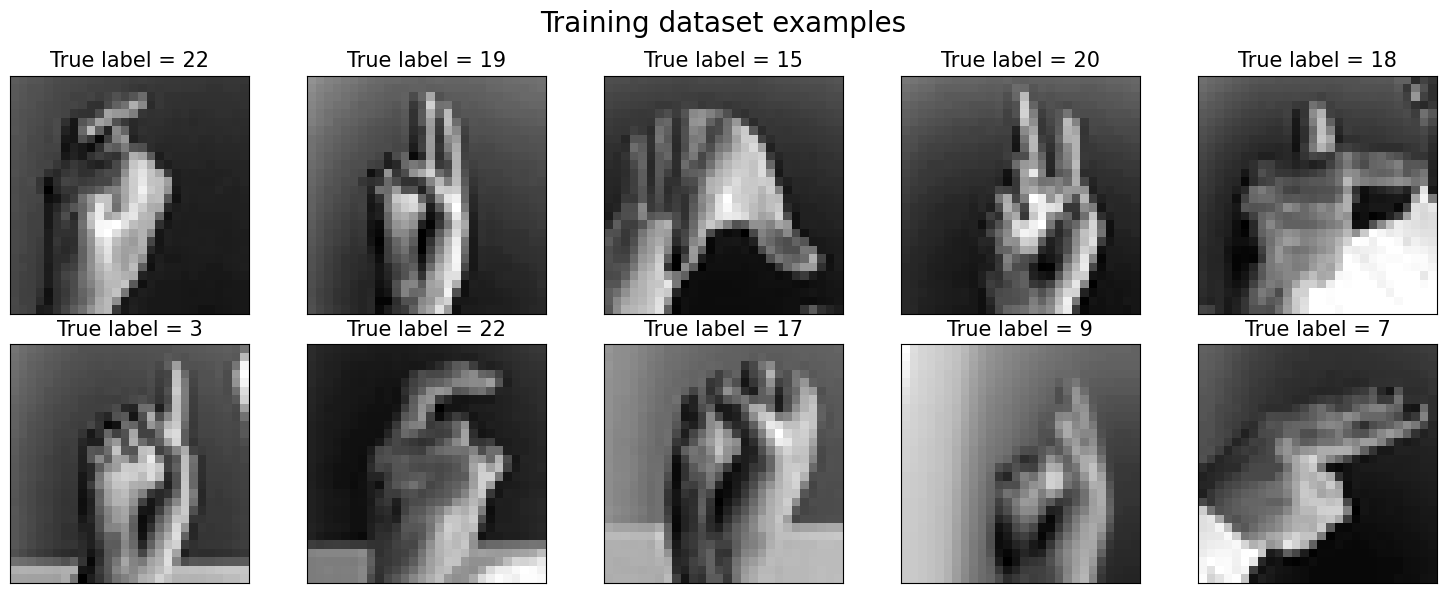

In [45]:
# Plotting training examples
fig = plt.figure(figsize=(15, 6))
for i, (data, label) in itertools.islice(enumerate(training_dataset), 10):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(data.numpy().reshape(28, 28), cmap='gray_r')
    ax.set_title(f'True label = {int(label)}', size=15)
plt.suptitle("Training dataset examples", fontsize=20)
plt.tight_layout()
plt.show()

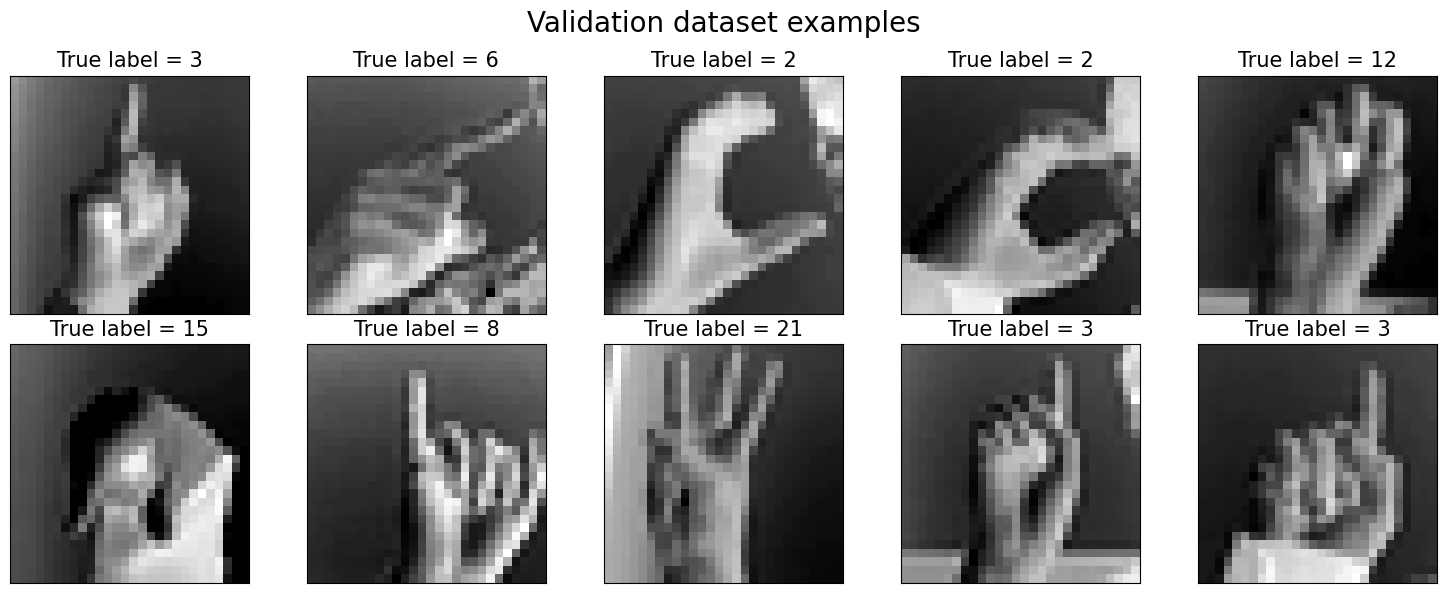

In [46]:
# Plotting validation examples
fig = plt.figure(figsize=(15, 6))
for i, (data, label) in itertools.islice(enumerate(validation_dataset), 10):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(data.numpy().reshape(28, 28), cmap='gray_r')
    ax.set_title(f'True label = {int(label)}', size=15)
plt.suptitle("Validation dataset examples", fontsize=20)
plt.tight_layout()
plt.show()

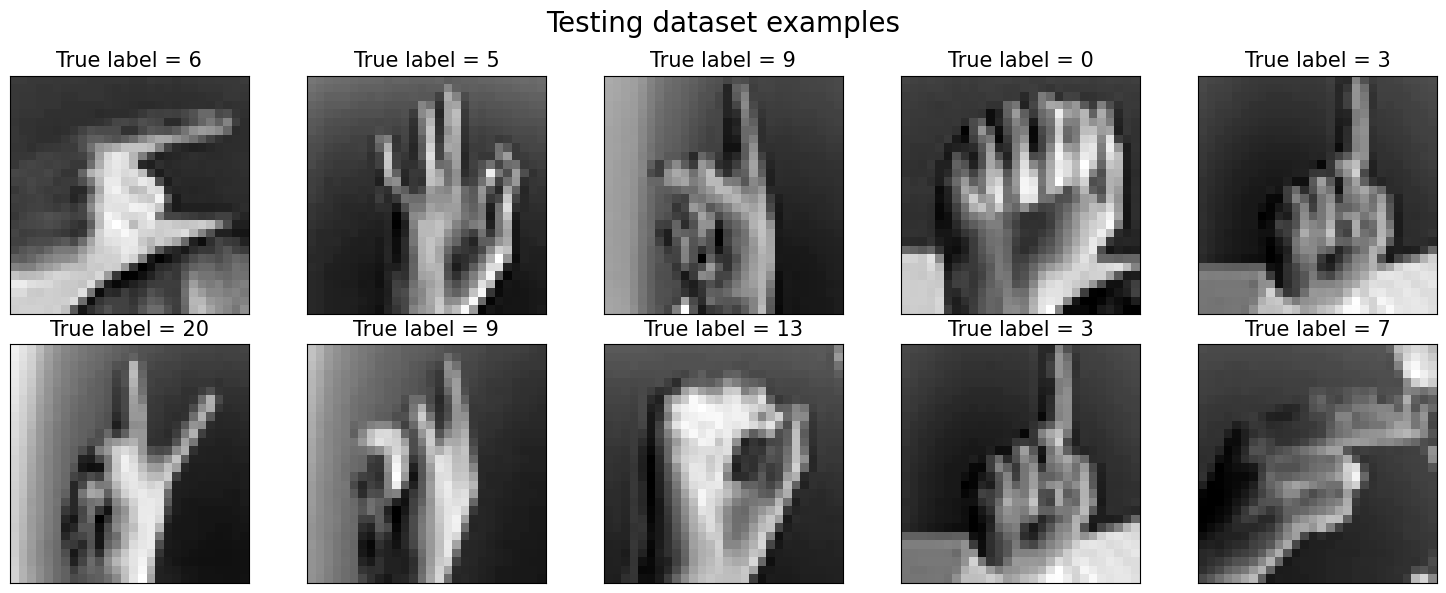

In [47]:
# Plotting testing examples
fig = plt.figure(figsize=(15, 6))
for i, (data, label) in itertools.islice(enumerate(testing_dataset), 10):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(data.numpy().reshape(28, 28), cmap='gray_r')
    ax.set_title(f'True label = {int(label)}', size=15)
plt.suptitle("Testing dataset examples", fontsize=20)
plt.tight_layout()
plt.show()

## Plotting class labels shares

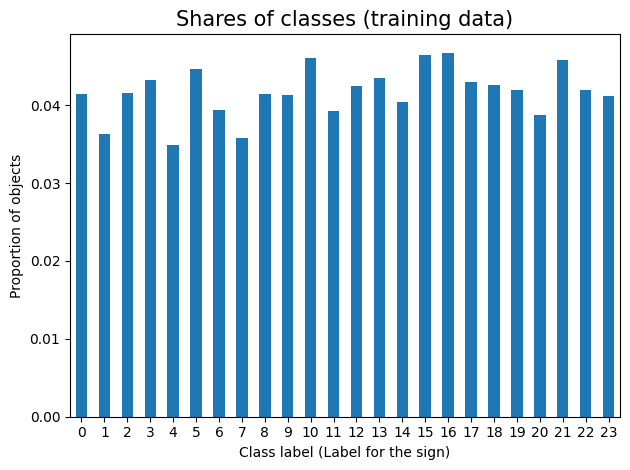

In [48]:
training_labels = training_dataset[:][1].int()

unique_training_labels = np.unique(training_labels)

training_labels_count = np.bincount(training_labels)

n_train = training_labels.shape[0]

labels_info_share = pd.Series(
    training_labels_count, index=unique_training_labels
) / n_train

labels_info_share.plot(kind="bar")
plt.xticks(rotation=0)
plt.title("Shares of classes (training data)", fontsize=15)
plt.xlabel("Class label (Label for the sign)")
plt.ylabel("Proportion of objects")
plt.tight_layout()
plt.show()

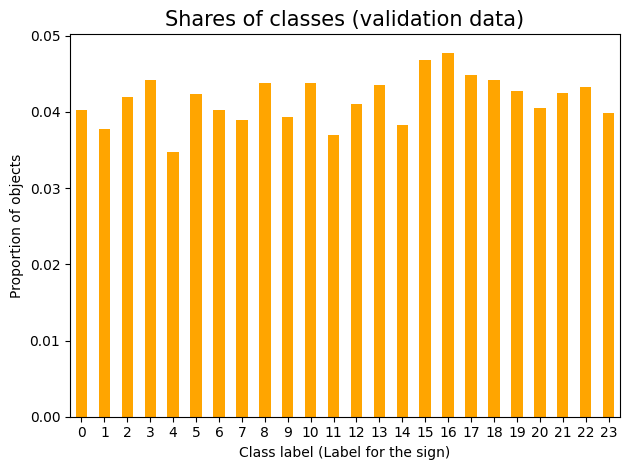

In [49]:
validation_labels = validation_dataset[:][1].int()

unique_validation_labels = np.unique(validation_labels)

validation_labels_count = np.bincount(validation_labels)

n_valid = validation_labels.shape[0]

labels_info_share = pd.Series(
    validation_labels_count, index=unique_validation_labels
) / n_valid

labels_info_share.plot(kind="bar", color="orange")
plt.xticks(rotation=0)
plt.title("Shares of classes (validation data)", fontsize=15)
plt.xlabel("Class label (Label for the sign)")
plt.ylabel("Proportion of objects")
plt.tight_layout()
plt.show()

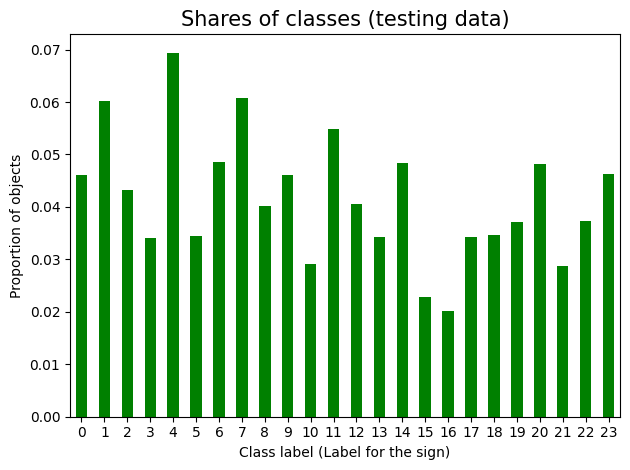

In [50]:
testing_labels = testing_dataset[:][1].int()

unique_testing_labels = np.unique(testing_labels)

testing_labels_count = np.bincount(testing_labels)

n_test = testing_labels.shape[0]

labels_info_share = pd.Series(
    testing_labels_count, index=unique_testing_labels
) / n_test

labels_info_share.plot(kind="bar", color="green")
plt.xticks(rotation=0)
plt.title("Shares of classes (testing data)", fontsize=15)
plt.xlabel("Class label (Label for the sign)")
plt.ylabel("Proportion of objects")
plt.tight_layout()
plt.show()

# Creating Dataloaders

In [51]:
torch.manual_seed(RANDOM_SEED)

batch_size = 64

training_dataloader = DataLoader(
    training_dataset,
    batch_size=batch_size, 
    shuffle=True,
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=batch_size, 
    shuffle=False,
)

testing_dataloader = DataLoader(
    testing_dataset,
    batch_size=batch_size, 
    shuffle=False,
)

# Building a CNN

In [52]:
sign_mnist_classifier = nn.Sequential()

# Convolutional Layer #1
sign_mnist_classifier.add_module(
    "conv1",
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
    )
# Activation for Convolutional Layer #1
sign_mnist_classifier.add_module("relu1", nn.ReLU())

# Max-Pooling Layer #1
sign_mnist_classifier.add_module("pool1", nn.MaxPool2d(kernel_size=2))

# Convolutional Layer #2
sign_mnist_classifier.add_module(
    "conv2", 
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
    )
# Activation for Convolutional Layer #2
sign_mnist_classifier.add_module("relu2", nn.ReLU())

# Max-Pooling Layer #2
sign_mnist_classifier.add_module("pool2", nn.MaxPool2d(kernel_size=2))

# Flatten Layer
sign_mnist_classifier.add_module("flatten", nn.Flatten())

# Fully Connected Layer #1
sign_mnist_classifier.add_module('fc1', nn.Linear(3136, 1024))
# Activation for Fully Connected Layer #1
sign_mnist_classifier.add_module('relu3', nn.ReLU())

# Dropout
sign_mnist_classifier.add_module('dropout', nn.Dropout(p=0.5))

# Fully Connected Layer #2
sign_mnist_classifier.add_module('fc2', nn.Linear(1024, 24))

In [53]:
sign_mnist_classifier.eval()

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=24, bias=True)
)

# Training/validation loop

In [54]:
def train(
    model, 
    loss_func, 
    optimizer,
    training_dataloader,
    validation_dataloader,
    epochs=10,
    enable_logging=False,
    device=DEVICE,
):
    """Trains the neural net."""
    
    # Preallocating the arrays for losses and accuracies
    loss_history_train = [0] * epochs
    accuracy_history_train = [0] * epochs
    loss_history_valid = [0] * epochs
    accuracy_history_valid = [0] * epochs
    
    # Launching the algorithm
    for epoch in range(epochs):
        
        # Enabling training mode
        model.train()
        
        # Considering each batch for the current epoch
        for x_batch, y_batch in training_dataloader:
            
            # Moving data to GPU
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Generating predictions for the batch
            model_predictions = model(x_batch)
            
            # Computing the loss
            loss = loss_func(model_predictions, y_batch.long())
            
            # Computing gradients
            loss.backward()
            
            # Updating parameters using gradients
            optimizer.step()
            
            # Resetting the gradients to zero
            optimizer.zero_grad()
            
            # Adding the batch-level loss and accuracy to history
            loss_history_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (
                torch.argmax(model_predictions, dim=1) == y_batch
            ).float()
            accuracy_history_train[epoch] += is_correct.sum().cpu()
            
            # Computing epoch-level loss and accuracy
        loss_history_train[epoch] /= len(training_dataloader.dataset)
        accuracy_history_train[epoch] /= len(training_dataloader.dataset)
        
        # Enabling evaluation mode
        model.eval()
        
        # Testing the CNN on the validation set
        with torch.no_grad():
            
            # Considering each batch for the current epoch
            for x_batch, y_batch in validation_dataloader:
                
                # Moving data to GPU
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                
                # Generating predictions for the batch
                model_predictions = model(x_batch)
            
                # Computing the loss
                loss = loss_func(model_predictions, y_batch.long())
                
                # Adding the batch-level loss and accuracy to history
                loss_history_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (
                    torch.argmax(model_predictions, dim=1) == y_batch
                ).float()
                accuracy_history_valid[epoch] += is_correct.sum().cpu()
                
        # Computing epoch-level loss and accuracy
        loss_history_valid[epoch] /= len(validation_dataloader.dataset)
        accuracy_history_valid[epoch] /= len(validation_dataloader.dataset)
        
        # Logging the training process
        if enable_logging:
            print(
                "Epoch {}/{}\n"
                "train_loss = {:.4f}, train_accuracy = {:.4f} | "
                "valid_loss = {:.4f}, valid_accuracy = {:.4f}".format(
                epoch + 1,
                epochs,
                loss_history_train[epoch], 
                accuracy_history_train[epoch],
                loss_history_valid[epoch],
                accuracy_history_valid[epoch],
                )
            )
            
    return (
        model, 
        loss_history_train, 
        accuracy_history_train,
        loss_history_valid,
        accuracy_history_valid,
    )

In [55]:
sign_mnist_classifier = sign_mnist_classifier.to(DEVICE)

# Training the CNN

In [56]:
# Defining the loss function (multiclass classification)
loss_func = nn.CrossEntropyLoss()

# Defining the learning rate
learning_rate = 0.001

# Defining the optimizer
optimizer = torch.optim.Adam(
    sign_mnist_classifier.parameters(), lr=learning_rate
)

In [ ]:
# Setting the random seed
torch.manual_seed(RANDOM_SEED)

# Training the CNN
(
sign_mnist_classifier,
loss_history_train, 
accuracy_history_train,
loss_history_valid,
accuracy_history_valid 
) = train(
    model=sign_mnist_classifier,
    loss_func=loss_func,
    optimizer=optimizer,
    training_dataloader=training_dataloader,
    validation_dataloader=validation_dataloader,
    epochs=8,
    enable_logging=True,
)

Epoch 1/8
train_loss = 1.2856, train_accuracy = 0.6054 | valid_loss = 0.2812, valid_accuracy = 0.9302
Epoch 2/8
train_loss = 0.1723, train_accuracy = 0.9476 | valid_loss = 0.0605, valid_accuracy = 0.9876
Epoch 3/8
train_loss = 0.0496, train_accuracy = 0.9873 | valid_loss = 0.0058, valid_accuracy = 1.0000
Epoch 4/8
train_loss = 0.0197, train_accuracy = 0.9951 | valid_loss = 0.0064, valid_accuracy = 0.9999
Epoch 5/8
train_loss = 0.0148, train_accuracy = 0.9965 | valid_loss = 0.0031, valid_accuracy = 1.0000
Epoch 6/8
train_loss = 0.0078, train_accuracy = 0.9985 | valid_loss = 0.0007, valid_accuracy = 1.0000
Epoch 7/8
train_loss = 0.0104, train_accuracy = 0.9980 | valid_loss = 0.0011, valid_accuracy = 1.0000


In [ ]:
# Plotting training/validation loss
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_history_train, lw=3)
ax.plot(loss_history_valid, lw=3)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(['Training loss', 'Validation loss'], fontsize=15)

# Plotting training/validation accuracy
ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_history_train, lw=3)
ax.plot(accuracy_history_valid, lw=3)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(['Training accuracy', 'Validation accuracy'], fontsize=15)

plt.tight_layout() 
plt.show()

# Making test predictions

In [ ]:
def evaluate_test_by_batch(model, testing_dataloader, device=DEVICE):
    """Computes predictions and accuracy for the Dataloader."""
    # Initializing the counter for accuracy
    accuracy_test = 0
    # Initializing a list for storing predictions
    test_predictions = []
    # Setting the model to the evaluation model
    model.eval()
    # Computing accuracy and predictions
    with torch.no_grad():
        for x_batch, y_batch in testing_dataloader:
            # Moving data to GPU
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            # Computing predictions for the batch
            test_batch_predictions = torch.argmax(model(x_batch), dim=1)
            # Adding the batch predictions to the prediction list
            test_predictions.append(test_batch_predictions)
            # Computing the test accuracy
            is_correct = (test_batch_predictions == y_batch).float()
            accuracy_test += is_correct.sum().cpu()
    
    # Transforming a list of tensors into one tensor
    test_predictions_tensor = torch.cat(test_predictions).cpu()
    # Finishing computing test accuracy
    accuracy_test /= len(testing_dataloader.dataset)
    
    return accuracy_test, test_predictions_tensor

In [60]:
accuracy_test, predictions_test = evaluate_test_by_batch(
    model=sign_mnist_classifier, testing_dataloader=testing_dataloader
)
print(f"Test accuracy: {accuracy_test:.4f}")

Test accuracy: 0.9385


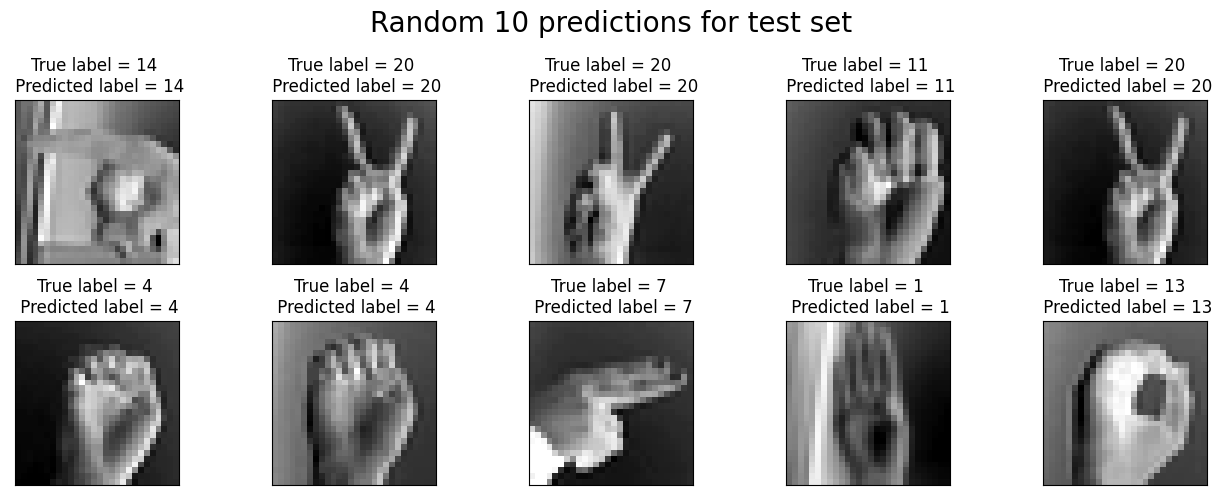

In [61]:
nums = np.random.randint(low=0, high=x_test.shape[0], size=10)
fig = plt.figure(figsize=(13, 5))
for i, num in enumerate(nums):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_test[num].numpy().reshape(28, 28), cmap="gray_r")
    ax.set_title(f"True label = {y_test[num].int()} \n Predicted label = {predictions_test[num]}")
plt.suptitle("Random 10 predictions for test set", fontsize=20)
plt.tight_layout()
plt.show()

In [62]:
target_names = [
    "A", "B", "C", "D", "E", "F", 
    "G", "H", "I", "K", "L", "M",
    "N", "O", "P", "Q", "R", "S",
    "T", "U", "V", "W", "X", "Y",
]

print(classification_report(
    y_true=y_test, 
    y_pred=predictions_test, 
    target_names=target_names,
)
     )

              precision    recall  f1-score   support

           A       0.94      1.00      0.97       331
           B       1.00      1.00      1.00       432
           C       0.91      1.00      0.95       310
           D       1.00      1.00      1.00       245
           E       0.92      1.00      0.96       498
           F       0.96      1.00      0.98       247
           G       0.94      0.94      0.94       348
           H       0.96      0.95      0.96       436
           I       0.96      0.98      0.97       288
           K       0.91      0.94      0.93       331
           L       1.00      1.00      1.00       209
           M       0.89      0.92      0.91       394
           N       0.99      0.85      0.92       291
           O       1.00      0.84      0.91       246
           P       1.00      1.00      1.00       347
           Q       0.96      1.00      0.98       164
           R       0.84      0.81      0.82       144
           S       0.87    